In [1]:
%matplotlib inline
from google.cloud import storage
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
import numpy as np
from pathlib import Path

In [2]:
# Define bucket and blob prefix

label_bucket_name = 'catflap-photo-labels'
photo_bucket_name = 'catflap-photos-raw'

In [3]:
# Set up buckets

client = storage.Client()
label_bucket = client.get_bucket(label_bucket_name)
photo_bucket = client.get_bucket(photo_bucket_name)

In [4]:
# Get list of blob names

blobs = label_bucket.list_blobs()
blob_list = [blob.name for blob in blobs]
blob_list

['cat_detection_labels - 2020-05-11.csv',
 'cat_detection_labels - 2020-05-12.csv',
 'cat_detection_labels - 2020-05-13.csv',
 'cat_detection_labels - 2020-05-14.csv',
 'cat_detection_labels - 2020-05-15.csv',
 'cat_detection_labels - 2020-05-16.csv',
 'cat_detection_labels - 2020-05-17.csv']

In [5]:
# Read labels into pandas dataframe

df_list = []
for blob in blob_list:
    labels = pd.read_csv('gs://'+label_bucket_name+'/'+blob)
    df_list += [labels]
label_df = pd.concat(df_list, ignore_index=True, sort=False)

print(label_df.shape)
label_df.head()

(34142, 6)


,blob_location,contains_cat,in_or_out,entering_or_exiting,seen_through,proportion_of_cat
0,gs://catflap-photos-raw/2020-05-11_080042.jpg,False,NaN,NaN,NaN,NaN
1,gs://catflap-photos-raw/2020-05-11_080050.jpg,False,NaN,NaN,NaN,NaN
2,gs://catflap-photos-raw/2020-05-11_080058.jpg,False,NaN,NaN,NaN,NaN
3,gs://catflap-photos-raw/2020-05-11_080105.jpg,False,NaN,NaN,NaN,NaN
4,gs://catflap-photos-raw/2020-05-11_080112.jpg,False,NaN,NaN,NaN,NaN


In [6]:
# Check data types

label_df.dtypes

blob_location           object
contains_cat              bool
in_or_out               object
entering_or_exiting     object
seen_through            object
proportion_of_cat      float64
dtype: object

In [7]:
# Count in_or_out_labels

label_df.contains_cat.value_counts()

False    33434
True       708
Name: contains_cat, dtype: int64

In [8]:
# Calculate proportion of photos that Thomas is in

thomas_is_in = (label_df.contains_cat.sum() / len(label_df)) * 100
print('Thomas is in {:0.1f}% of photos'.format(thomas_is_in))

Thomas is in 2.1% of photos


In [9]:
# Count in_or_out labels

label_df.in_or_out.value_counts(dropna=False)

NaN    33434
out      588
in       120
Name: in_or_out, dtype: int64

Thomas is outside in most of the photos containing a cat

In [10]:
# Calculate proportion of Thomas photos in which he's outside

thomas_is_outside = (label_df.in_or_out=='in').sum() / label_df.in_or_out.notnull().sum() * 100
print('Thomas is inside in {:0.1f}% of photos that he\'s in'.format(thomas_is_outside))

Thomas is inside in 16.9% of photos that he's in


In [11]:
# Count enter_or_exit labels

label_df.entering_or_exiting.value_counts(dropna=False)

NaN         34117
exiting        20
entering        5
Name: entering_or_exiting, dtype: int64

- We very rarely catch him as he's passing through the cat flap
- He seems to be slower to exit than to enter. Probably because he tests whether it's unlocked with his paw first

In [12]:
# Count seen_through labels

label_df.seen_through.value_counts(dropna=False)

NaN        33731
window       391
catflap       20
Name: seen_through, dtype: int64

If he's seen outside, it's more likely through the window than the cat flap

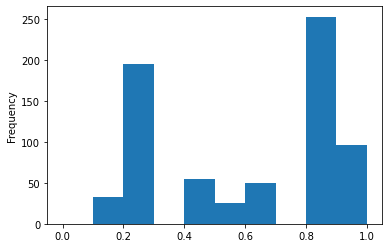

In [13]:
# Plot histogram of proportion of Thomas which is in each photo

label_df.proportion_of_cat.plot.hist(bins=np.arange(0,1.1,0.1))

In [14]:
# Get positive examples

interesting_blobs = label_df[label_df.contains_cat]
interesting_blobs = interesting_blobs[interesting_blobs.in_or_out == 'in']
interesting_blobs = interesting_blobs[interesting_blobs.proportion_of_cat>.8]

print(interesting_blobs.shape)
interesting_blobs.head()

(32, 6)


,blob_location,contains_cat,in_or_out,entering_or_exiting,seen_through,proportion_of_cat
98,gs://catflap-photos-raw/2020-05-11_081307.jpg,True,in,NaN,NaN,1.0
99,gs://catflap-photos-raw/2020-05-11_081314.jpg,True,in,NaN,NaN,1.0
100,gs://catflap-photos-raw/2020-05-11_081325.jpg,True,in,NaN,NaN,1.0
101,gs://catflap-photos-raw/2020-05-11_081332.jpg,True,in,NaN,NaN,1.0
247,gs://catflap-photos-raw/2020-05-11_083124.jpg,True,in,entering,NaN,1.0


In [15]:
# Extract blob name from full location

interesting_blobs['photo_blob'] = interesting_blobs.blob_location.str.split('/').apply(lambda x: x[-1])

interesting_blobs.head()

,blob_location,contains_cat,in_or_out,entering_or_exiting,seen_through,proportion_of_cat,photo_blob
98,gs://catflap-photos-raw/2020-05-11_081307.jpg,True,in,NaN,NaN,1.0,2020-05-11_081307.jpg
99,gs://catflap-photos-raw/2020-05-11_081314.jpg,True,in,NaN,NaN,1.0,2020-05-11_081314.jpg
100,gs://catflap-photos-raw/2020-05-11_081325.jpg,True,in,NaN,NaN,1.0,2020-05-11_081325.jpg
101,gs://catflap-photos-raw/2020-05-11_081332.jpg,True,in,NaN,NaN,1.0,2020-05-11_081332.jpg
247,gs://catflap-photos-raw/2020-05-11_083124.jpg,True,in,entering,NaN,1.0,2020-05-11_083124.jpg


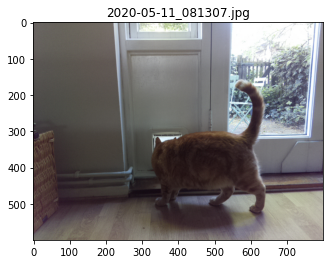

In [16]:
# Plot interesting images

for blob_name in interesting_blobs.photo_blob:
    
    blob = photo_bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = mpimg.imread(bytes_io, format='jpg')
    plt.figure()
    plt.imshow(img)
    plt.title(blob_name)
    break

In [17]:
# Save interesting images to disk

dir_path = '/home/jupyter/thomas_photos/'
Path(dir_path).mkdir(parents=True, exist_ok=True)

for blob_name in interesting_blobs.photo_blob:
    
    blob = photo_bucket.blob(blob_name)
    blob.download_to_filename(dir_path+blob_name)
    break